# Phenotype Graph Tutorial

In this tutorial, I go through how to use `PhenotypeGraphfun.py` and `ReducePhenotypeGraph.py` to construct a Phenotype Graph from a specified Phenotype Pattern, as well as the condensation of the Phenotype Graph. `PhenotypeGraphviz.py` can be used to visulize these graphs, however, this is only useful when the graphs are fairly small.

In [1]:
import DSGRN
from DSGRN import *

import sys
sys.setrecursionlimit(10**8)
sys.path.insert(0,'/home/elizabeth/Desktop/GIT/dsgrn_acdc/src')

from PGDraw import *
from MGsearchthroughPG import *
from NsearchgoeQuery import *
from stats import *
from PhenotypeGraphviz import *
from PhenotypeGraphFun import *
from ReducePhenotypeGraph import *

In [2]:
database = Database("/home/elizabeth/Desktop/ACDC/TFPYI_test.db") 
network = Network("/home/elizabeth/Desktop/ACDC/TFPYI_test") 

In [3]:
parameter_graph = ParameterGraph(network)
print(parameter_graph.size())

42


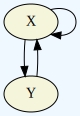

In [4]:
DrawGraph(network)

In [5]:
PGGraph(database, network) # creates a png of the parameter graph.

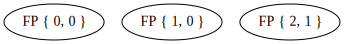

In [6]:
database.DrawMorseGraph(4) 

First we need to decide what the path is we are looking for, each step in the path needs to have a fixed point in it that we are looking for. Below, bds00, bds20,... are how we code fixed points in DSGRN. So if you want to find a path that has a parameter graph node with fixed point {0,0} and fixed point {2,0}, you would mark this as a list [bds00, bds20]. Then the entire path is a list of lists that you wish your path to follow. An example of this are in lists `D` and `E` below. This is called the **Phenotype Pattern**.

In [7]:
bds00 = {"X":0, "Y":0} #FP {0,0}
bds20 = {"X":2, "Y":0} #FP {2,0}
bds21 = {"X":2, "Y":1} #FP {2,1}
bds11 = {"X":1, "Y":1} #FP {1,1}
bds10 = {"X":1, "Y":0} #FP {1,0}
bds01 = {"X":0, "Y":1} #FP {0,1}

D = [[bds00,bds20], [bds00, bds21], [bds21], [bds00, bds21], [bds00, bds21, bds11], [bds11, bds21], [bds01, bds21]]
#2 3 6 3 7 8 5
E = [[bds00, bds10],[bds00, bds21, bds10], [bds00, bds21], [bds01, bds21]]


The `get_paramslist()` function then finds all of the parameter nodes assosiated to the phenotype pattern. You can either search for Morse Graphs that have ONLY the fixed points in the phenotype pattern ('='), or have AT LEAST the fixed points in the phenotype pattern ('<').

In [8]:
%%capture
paramslist = get_paramslist(database, D, '=')
paramslist

Next, we create the **Phenotype Graph**, this is a directed subgraph of the parameter graph created by DSGRN. 

In [9]:
edges = get_phenotype_graph(database, paramslist)
edges

{(0, 4): [(0, 25), (0, 6), (1, 11)],
 (0, 6): [(1, 13), (0, 27), (0, 4)],
 (0, 25): [(0, 27), (0, 4)],
 (0, 27): [(1, 34), (0, 6), (0, 25)],
 (1, 7): [(1, 9), (1, 28)],
 (1, 9): [(2, 16), (1, 7)],
 (1, 11): [(1, 13), (2, 18)],
 (1, 13): [(1, 34), (1, 11), (2, 20)],
 (1, 28): [(1, 29), (1, 7)],
 (1, 29): [(1, 28)],
 (1, 33): [(1, 34), (2, 40)],
 (1, 34): [(1, 13), (1, 33), (2, 41)],
 (2, 16): [(3, 9), (2, 17)],
 (2, 17): [(2, 16), (2, 19), (2, 18)],
 (2, 18): [(2, 20), (3, 11), (2, 17)],
 (2, 19): [(2, 40), (2, 20), (2, 17)],
 (2, 20): [(2, 18), (2, 19), (2, 41), (3, 13)],
 (2, 40): [(3, 33), (2, 19), (2, 41)],
 (2, 41): [(2, 40), (3, 34), (2, 20)],
 (3, 7): [(3, 9), (3, 28)],
 (3, 9): [(3, 7), (4, 30)],
 (3, 11): [(3, 13), (4, 32)],
 (3, 13): [(3, 34), (3, 11)],
 (3, 28): [(3, 7), (4, 30), (3, 29)],
 (3, 29): [(4, 31), (3, 28)],
 (3, 33): [(3, 34), (4, 31)],
 (3, 34): [(3, 13), (3, 33), (4, 32)],
 (4, 30): [(4, 31), (5, 37)],
 (4, 31): [(5, 38), (4, 30), (4, 32)],
 (4, 32): [(4, 31), (

The **condensation** of the Phenotype Graph finds all of the strongly connected components and reduces it according to those groups. Currently, this function returns three objects. The first it the condensation of the Phenotype Graph, the next is the reduction of the parameter list and the last is the strongly connected components.

In [10]:
[a,b,c] = reduce(edges, paramslist)

In [11]:
a

{(0, 4): [(1, 34)],
 (1, 7): [(2, 18)],
 (1, 34): [(2, 18)],
 (2, 18): [(3, 33), (3, 9)],
 (3, 9): [(4, 32)],
 (3, 33): [(4, 32)],
 (4, 32): [(5, 38)],
 (5, 38): [(6, 36), (6, 35)],
 (6, 14): [],
 (6, 15): [],
 (6, 35): [],
 (6, 36): []}

We can visulize both the Phenotype Graph and its condensation. The different colors correspond to different layers (i.e, the steps of the Phenotype Pattern). These save as png files.

In [12]:
PhenotypeGraphviz(database, network, edges, 'PhenotypeGraph1')

In [13]:
PhenotypeGraphviz(database, network, a, 'PhenotypeGraphCond1')

We can also look for paths in either graph, this following function returns the first path found only.

In [14]:
find_a_path(edges,paramslist[0],paramslist[-1],100)

[[(0, 4),
  (0, 25),
  (0, 27),
  (1, 34),
  (1, 13),
  (1, 11),
  (2, 18),
  (2, 20),
  (2, 19),
  (2, 40),
  (3, 33),
  (3, 34),
  (3, 13),
  (3, 11),
  (4, 32),
  (4, 31),
  (5, 38),
  (6, 36)]]

In [15]:
find_a_path(a,b[0],b[-1],100)

[[(0, 4), (1, 34), (2, 18), (3, 33), (4, 32), (5, 38), (6, 36)]]

Below we have another example to show that these functions work quickly on a larger network.

In [16]:
database = Database("/home/elizabeth/Desktop/ACDC/ACDC_FullconnE.db") 
network = Network("/home/elizabeth/Desktop/ACDC/ACDC_FullconnE") 

In [17]:
parameter_graph = ParameterGraph(network)
print(parameter_graph.size())

38416


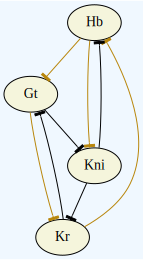

In [18]:
DrawGraph(network)

In [19]:
AP35 = {"Hb":[0,2], "Gt":2, "Kr":0, "Kni":0}
AP37 = {"Hb":2, "Gt":[0,1], "Kr":0, "Kni":0}
AP40 = {"Hb":2, "Gt":1, "Kr":[0,1], "Kni":0} #edit
AP45 = {"Hb":[0,1], "Gt":1, "Kr":2, "Kni":0} #edit
AP47 = {"Hb":[0,1], "Gt":0, "Kr":2, "Kni":0} 
AP51 = {"Hb":1, "Gt":0, "Kr":2, "Kni":[0,1]} #edit
AP57 = {"Hb":1, "Gt":0, "Kr":[0,1], "Kni":2} #edit
AP61 = {"Hb":0, "Gt":0, "Kr":[0,1], "Kni":2}
AP63 = {"Hb":0, "Gt":[0,1], "Kr":1, "Kni":2} #edit
AP67 = {"Hb":0, "Gt":2, "Kr":1, "Kni":[0,1]} #edit

In [25]:
%%capture
D = [[AP37], [AP40], [AP45], [AP47], [AP51], [AP57], [AP61], [AP63], [AP67]]
paramslist = get_paramslist(database, D, '=')
paramslist

In [21]:
edges = get_phenotype_graph(database, paramslist)
edges

{(0, 14): [(1, 21),
  (0, 19222),
  (1, 19222),
  (0, 21),
  (0, 2415),
  (1, 16),
  (1, 14),
  (0, 9618),
  (1, 2415),
  (1, 9618),
  (0, 16),
  (0, 63),
  (1, 63)],
 (0, 21): [(1, 21),
  (0, 2422),
  (1, 2422),
  (1, 9625),
  (1, 23),
  (0, 9625),
  (0, 14),
  (1, 14),
  (0, 70),
  (1, 70),
  (1, 28),
  (1, 19229),
  (0, 19229),
  (0, 23),
  (0, 28)],
 (0, 28): [(1, 21),
  (0, 9632),
  (0, 21),
  (1, 77),
  (0, 77),
  (1, 19236),
  (0, 30),
  (1, 28),
  (0, 19236),
  (1, 2429),
  (1, 9632),
  (0, 2429),
  (1, 30)],
 (0, 63): [(0, 65),
  (0, 2464),
  (0, 14),
  (1, 14),
  (0, 19271),
  (0, 70),
  (1, 70),
  (1, 19271),
  (1, 2464),
  (1, 65),
  (1, 63)],
 (0, 67): [(1, 67),
  (0, 410),
  (1, 410),
  (0, 18),
  (0, 9671),
  (1, 18),
  (0, 19275),
  (0, 74),
  (1, 9671),
  (1, 74),
  (1, 19275)],
 (0, 70): [(1, 21),
  (0, 21),
  (1, 77),
  (0, 19278),
  (1, 19278),
  (0, 77),
  (0, 2471),
  (1, 72),
  (1, 70),
  (0, 9674),
  (0, 63),
  (1, 2471),
  (1, 9674),
  (0, 72),
  (1, 63)],
 (0,

In [22]:
[a,b,c] = reduce(edges, paramslist)

In [24]:
a

{(0, 14): [(1, 21), (1, 21)],
 (1, 21): [(2, 36432), (2, 36432)],
 (2, 36432): [(3, 36523), (3, 36523)],
 (3, 36523): [(4, 36509), (4, 36509)],
 (4, 36509): [(5, 34121), (5, 34121)],
 (5, 34121): [(6, 34120), (6, 34120)],
 (6, 34120): [(7, 14912), (7, 14912)],
 (7, 14912): [(8, 5308),
  (8, 4949),
  (8, 5635),
  (8, 8036),
  (8, 8379),
  (8, 9065),
  (8, 147),
  (8, 161),
  (8, 833),
  (8, 847),
  (8, 3234),
  (8, 3248),
  (8, 490),
  (8, 492),
  (8, 504),
  (8, 506),
  (8, 1176),
  (8, 1178),
  (8, 1190),
  (8, 1192),
  (8, 1862),
  (8, 1864),
  (8, 1876),
  (8, 1878),
  (8, 2548),
  (8, 2562),
  (8, 2891),
  (8, 2905),
  (8, 4963),
  (8, 5292),
  (8, 5294),
  (8, 5306),
  (8, 5649),
  (8, 5978),
  (8, 5980),
  (8, 5992),
  (8, 5994),
  (8, 6664),
  (8, 6666),
  (8, 6678),
  (8, 6680),
  (8, 7350),
  (8, 7364),
  (8, 7693),
  (8, 7707),
  (8, 8050),
  (8, 8393),
  (8, 9079),
  (8, 3577),
  (8, 3591),
  (8, 4263),
  (8, 4277),
  (8, 24157),
  (8, 19355),
  (8, 19369),
  (8, 24171),
  (